In [151]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import re
import math
from matplotlib.gridspec import GridSpec

In [152]:
data = pd.read_excel('../data/Data_extraction_model_results.xlsx')

In [153]:
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 12

class Timeline:
    _PALETTE = {
        "Natural": "#009E73",  # bluish green
        "Injury":  "#D55E00",  # vermillion
        "Combat":  "#0072B2",  # blue
        "Other":   "#999999",  # gray
    }

    def __init__(self, data: pd.DataFrame):
        data = data.copy()

        # normalize trauma types into 4 buckets
        def _bucket(val):
            if pd.isna(val) or str(val).strip() == "":
                return "Other"
            s = str(val).strip()
            return s if s in ("Natural", "Injury", "Combat") else "Other"

        data["Trauma_group"] = data["Trauma_type"].apply(_bucket)

        data["__last_tp"] = data["Time_points"].apply(self._last_timepoint)
        df = (
            data.sort_values(["__last_tp", "Study"], ascending=[False, True])
                .reset_index(drop=True)
        )

        self.Study = df["Study"].tolist()
        self.timepoints = df["Time_points"].tolist()
        self.trauma_groups = df["Trauma_group"].tolist()
        self.ylist = range(4, 4*len(self.Study)+4, 4)

        # colors per study from palette
        self.colors = [self._PALETTE[g] for g in self.trauma_groups]

    def _tokens(self, s):
        if s is None or (isinstance(s, float) and np.isnan(s)) or (isinstance(s, pd.Series) and s.isna().all()):
            return []
        s = str(s).strip()
        if not s:
            return []
        return [t.strip() for t in s.split(',') if t.strip() and t.strip().lower() != 'nan']

    def _parse(self, token: str):
        if ':' in token:
            a, b = token.split(':', 1)
            try:
                a, b = float(a), float(b)
            except ValueError:
                return None
            if b < a:
                a, b = b, a
            return ("range", a, b)
        else:
            try:
                return ("point", float(token))
            except ValueError:
                return None

    def _last_timepoint(self, timepoints):
        parsed = [p for t in self._tokens(timepoints) if (p := self._parse(t)) is not None]
        xs = []
        for kind, *vals in parsed:
            xs.extend(vals)  # add both ends of ranges and single points
        return max(xs) if xs else float('-inf')  # missing/empty at top

    def plot_line(self, Study, timepoints, y, color):
        parsed = [p for t in self._tokens(timepoints) if (p := self._parse(t)) is not None]
        xs = []
        for kind, *vals in parsed:
            xs.extend(vals)
        if xs:
            plt.plot([min(xs), max(xs)], [y, y], '-', linewidth=1,
                     solid_capstyle='round', color=color)
        pts = []
        for kind, *vals in parsed:
            if kind == "range":
                a, b = vals
                plt.plot([a, b], [y, y], '-', linewidth=6,
                         solid_capstyle='round', color=color, alpha=0.5)
            else:
                pts.append(vals[0])
        if pts:
            plt.scatter(pts, [y]*len(pts), color=color, zorder=3)

    def set_yticks(self):
        plt.yticks(self.ylist, self.Study)

    def parse_citations(self, citations):
        parsed_citations = []
        for citation in citations:
            name_match = re.match(r'^([A-Za-z\s,.\-]+?)\s*,', citation)
            year_match = re.search(r'\((\d{4})\)', citation)
            name = name_match.group(1) if name_match else ''
            year = year_match.group(1) if year_match else ''
            result = f"{name.strip()} ({year})"
            parsed_citations.append(result)
        return parsed_citations

    def _make_legend(self, ax):
        # unique groups in current data, in palette order for consistency
        present_groups = [g for g in self._PALETTE if g in set(self.trauma_groups)]
        handles = [
            Line2D([0], [0], color=self._PALETTE[g], lw=6, alpha=0.8, label=g)
            for g in present_groups
        ]
        ax.legend(
            handles=handles, title="Trauma Type", frameon=False,
            loc="center left",           # legend’s left side
            bbox_to_anchor=(1.02, 0.9), # just right of axes, middle of y
            bbox_transform=ax.transAxes
        )
    
    def show(self):
        plt.figure(figsize=(10, 30))
        for study, tp, y, color in zip(self.Study, self.timepoints, self.ylist, self.colors):
            self.plot_line(study, tp, y, color)
        self.set_yticks()
        plt.axvline(x=0, color='black', linestyle='-')
        plt.title('Measurement Points of Included Studies')
        plt.xlabel('Time since Trauma (Months)')
        plt.tight_layout()
        ax = plt.gca()
        ax.margins(y=0.01)
        ax.margins(x=0.05)
        self._make_legend(ax)
        plt.show()

    def _plot_one_panel(self, ax, start_idx, end_idx, row_step: int = 4):
        sub_Study = self.Study[start_idx:end_idx]
        sub_timepoints = self.timepoints[start_idx:end_idx]
        sub_colors = self.colors[start_idx:end_idx]
        ylist = range(row_step, row_step * len(sub_Study) + row_step, row_step)
        for study, tp, y, color in zip(sub_Study, sub_timepoints, ylist, sub_colors):
            self.plot_line(study, tp, y, color)
        ax.set_yticks(list(ylist))
        ax.set_yticklabels(sub_Study)
        ax.axvline(x=0, color="black", linestyle="-")
        ax.margins(y=0.02, x=0.20)
        ax.tick_params(axis="y", labelsize=7)
        ax.tick_params(axis="x", labelsize=11)

    def show_split(
        self,
        ncols: int = 2,
        max_per_panel: int = 18,
        a4_landscape_inches=(11.69, 8.27),
        sharex: bool = True,
        xlabel: str = "Time since Trauma (Months)",
        show: bool = True,
        savepath: str | None = None,
        dpi: int = 300,
        num_panels: int | None = None,
        reverse_panels: bool = False,
        panel_wspace: float = 0.30,
        panel_hspace: float = 0.22,
        left: float = 0.06,
        right_margin: float = 0.92,
        top: float = 0.92,
        bottom: float = 0.10,
        row_step: int = 4,
        xlim: tuple[float, float] | None = None,
        x_pad: float = 0.08,
    ):
        total = len(self.Study)
        if num_panels is not None:
            panels = max(1, int(num_panels))
            index_chunks = np.array_split(np.arange(total), panels)
            ncols_eff = min(ncols, panels)
            nrows = math.ceil(panels / ncols_eff)
        else:
            panels = math.ceil(total / max_per_panel) if max_per_panel > 0 else 1
            ncols_eff = min(ncols, panels)
            nrows = math.ceil(panels / ncols_eff)
            index_chunks = [np.arange(p * max_per_panel, min((p + 1) * max_per_panel, total)) for p in range(panels)]
        if xlim is None:
            xs = []
            for tps in self.timepoints:
                for tok in self._tokens(tps):
                    p = self._parse(tok)
                    if p is None:
                        continue
                    _, *vals = p
                    xs.extend(vals)
            if xs:
                xmin, xmax = min(xs), max(xs)
                span = xmax - xmin if xmax > xmin else 1.0
                xmin -= span * x_pad
                xmax += span * x_pad
            else:
                xmin, xmax = -1.0, 1.0
        else:
            xmin, xmax = xlim
        fig = plt.figure(figsize=a4_landscape_inches, constrained_layout=False)
        gs = GridSpec(nrows=nrows, ncols=ncols_eff, figure=fig, left=left, right=right_margin, top=top, bottom=bottom, wspace=panel_wspace, hspace=panel_hspace)
        axes = []
        for p, idxs in enumerate(index_chunks):
            r, c = divmod(p, ncols_eff)
            if reverse_panels:
                c = ncols_eff - 1 - c
            ax = fig.add_subplot(gs[r, c], sharex=axes[0] if (sharex and axes) else None)
            axes.append(ax)
            start, end = (int(idxs.min()), int(idxs.max()) + 1) if len(idxs) else (0, 0)
            self._plot_one_panel(ax, start, end, row_step=row_step)
            ax.set_xlim(xmin, xmax)
            if r < nrows - 1:
                plt.setp(ax.get_xticklabels(), visible=False)
                ax.set_xlabel("")
            else:
                ax.set_xlabel(xlabel)
            if end - start == 0:
                ax.set_visible(False)
        present_groups = [g for g in self._PALETTE if g in set(self.trauma_groups)]
        handles = [Line2D([0], [0], color=self._PALETTE[g], lw=6, alpha=0.8, label=g) for g in present_groups]
        leg_ax = fig.add_axes([right_margin + 0.005, 0.15, 1 - right_margin - 0.03, 0.7])
        leg_ax.axis("off")
        leg_ax.legend(handles=handles, title="Trauma Type", frameon=False, loc="center left")
        if savepath:
            fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
        if show:
            plt.show()
        plt.close(fig)

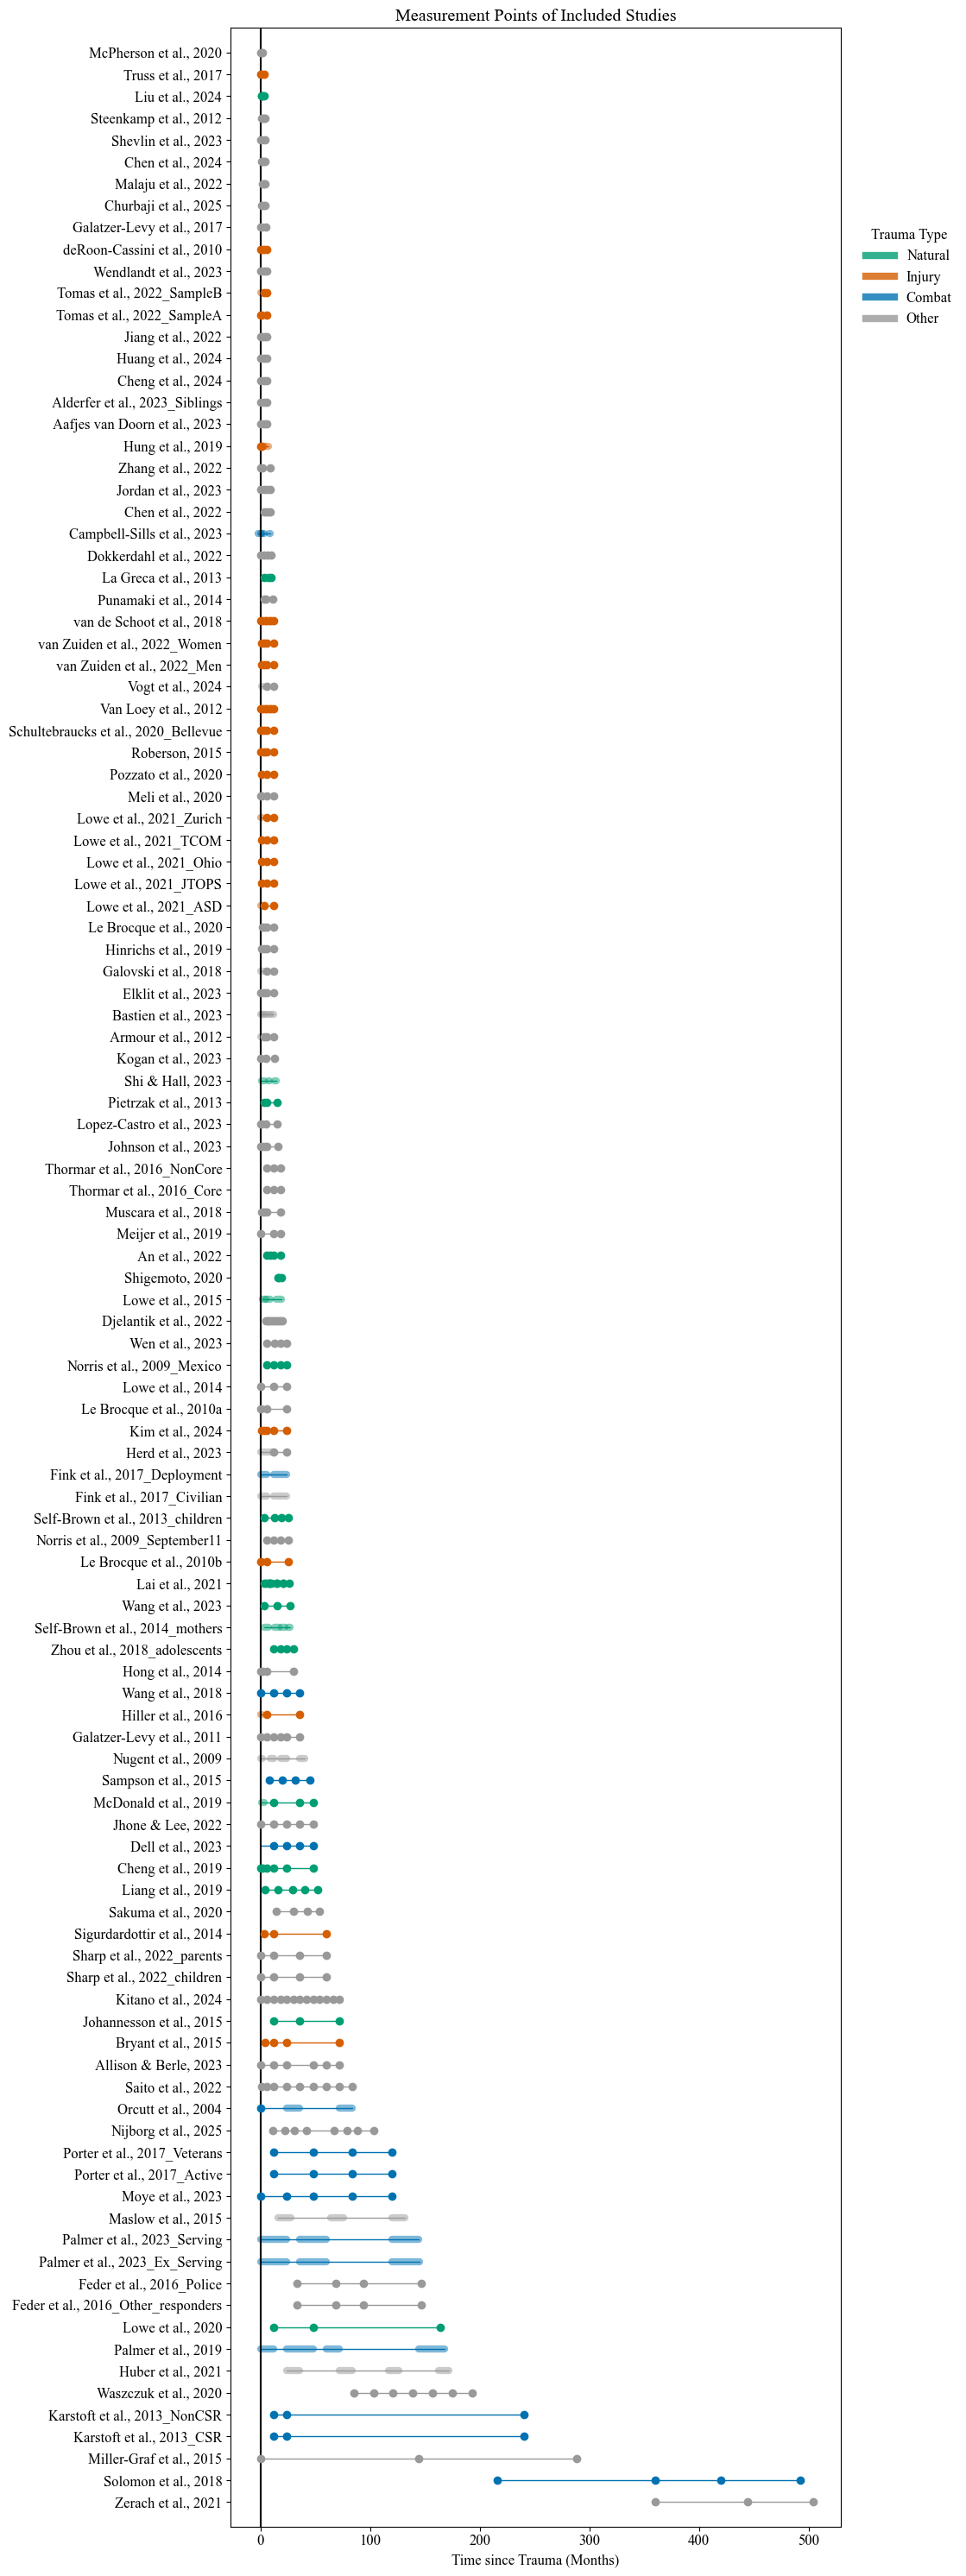

In [154]:
timeline = Timeline(data)
timeline.show()

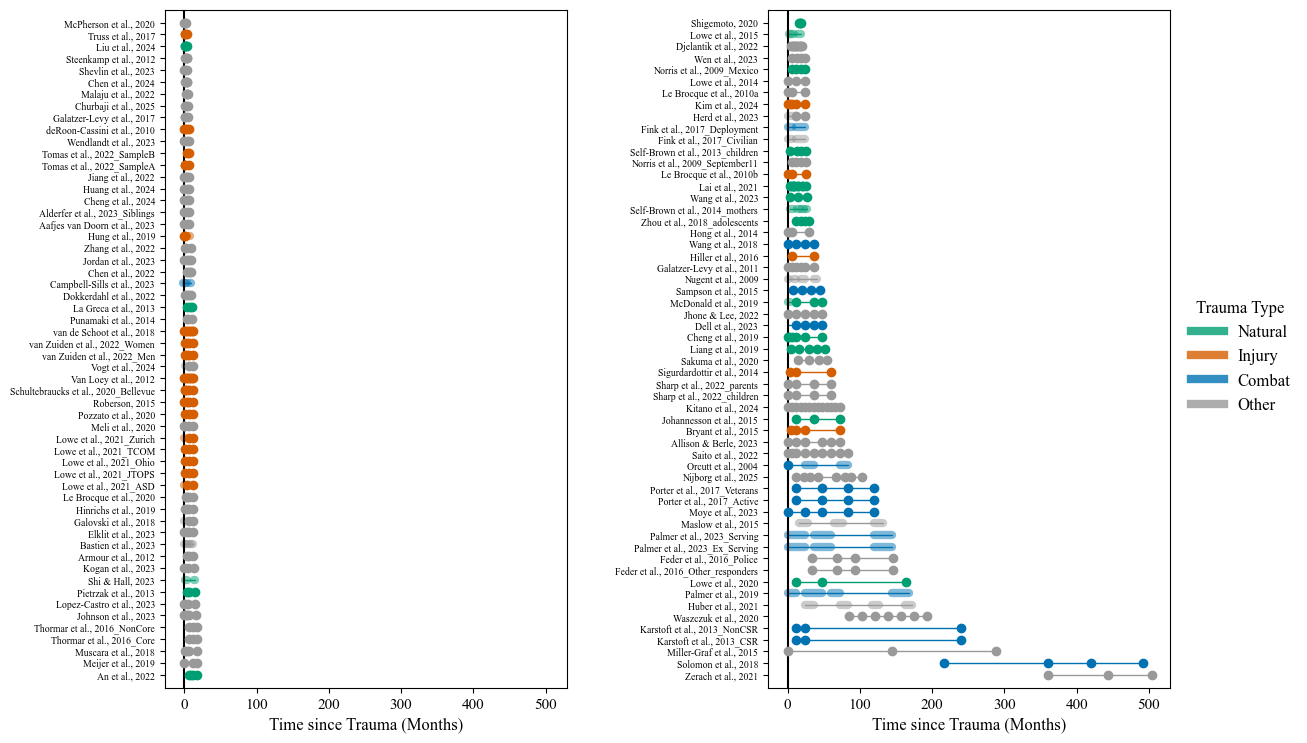

In [155]:
timeline = Timeline(data)
timeline.show_split(num_panels=2, ncols=2, reverse_panels = True, savepath="timeline_two_panels.png", panel_wspace=0.5, row_step=10, x_pad=0.05)